# Mass of B5-IRS1 from the C$^{18}$O emission

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from pvextractor import Path, extract_pv_slice, PathFromCenter
from spectral_cube.spectral_cube import SpectralCube
from astropy.coordinates import SkyCoord
import sys
import os
sys.path.append('../')
from B5setup import *
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.constants import G
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

## Obtain the position velocity diagram

In [2]:
lengtharcsec = 12 # in arcsec
widtharcsec = 0.4 # beam major
#centerra, centerdec = (ra_yso*u.deg, dec_yso*u.deg) # in degrees
centerra, centerdec = ((3+(47+(41.587/60))/60)*15 *u.deg, (32+(51+43.616/60)/60)*u.deg) # center of continuum emission
# pvextractor considers 0deg as South to North, we want to go approx. North to South
paangle = (67.1  -90 + 180) * u.deg # degrees, perpendicular to outflow and then N to S instead of S to N
cubename = '../../Barnard_5_data_back/cleaned_images/B5IRS1_C18O_robust05_multi.fits'
cubenameK = '../../Barnard_5_data_back/cleaned_images/B5IRS1_C18O_robust05_multi_K.fits'
pvfilename = 'data/B5IRS1_C18O_robust05_multi_K_PV_'+str(paangle)+'deg_'+str(lengtharcsec)+'arcsec_'+str(widtharcsec)+'width_cont_centered.fits'
pvarcsecfilename = 'data/B5IRS1_C18O_robust05_multi_K_PV_'+str(paangle)+'deg_'+str(lengtharcsec)+'arcsec_'+str(widtharcsec)+'width_cont_centered_arcsec.fits'

velinit = 7 * u.km/u.s
velend = 13 * u.km/u.s 

In [3]:
if not os.path.exists(cubenameK):
    cube = SpectralCube.read(cubename)
    cube.allow_huge_operations=True
    cube = cube.to(u.K)
    cube.write(cubenameK)
    cube = cube.spectral_slab(velinit, velend)
else:
    cube = SpectralCube.read(cubenameK).spectral_slab(velinit, velend)

if not os.path.exists(pvfilename):
    gcent = SkyCoord(centerra, centerdec)
    pathcent = PathFromCenter(center=gcent, length=lengtharcsec*u.arcsec, angle=paangle, width=widtharcsec*u.arcsec)
    slice1 = extract_pv_slice(cube, pathcent)
    slice1.header['CRPIX1'] = int(slice1.header['NAXIS1']/2) # by default the reference offset is the first pixel
    slice1.writeto(pvfilename)

if not os.path.exists(pvarcsecfilename):
    pvdata = fits.getdata(pvfilename)
    pvheader = fits.getheader(pvfilename)
    pvdata = np.flip(pvdata, axis=0) # so that the velocities grow instead of decreasing
    pvheader['CDELT1'] = pvheader['CDELT1']*3600 # we just change the unit to be able to use it with Cote's code
    pvheader['CUNIT1'] = 'arcsec'
    if np.sign(pvheader['CDELT2'])<0:
        velinit = pvheader['CRVAL2'] + pvheader['CDELT2'] * (pvheader['NAXIS2'] - pvheader['CRPIX2']) # this is the velocity in the new first pixel
        pvheader['CRPIX2'] = 1 # the first pixel is our new reference
        pvheader['CRVAL2'] = velinit # the first pixel will have the lowest velocity
        pvheader['CDELT2'] *= -1 
    hdu = fits.PrimaryHDU(data=pvdata, header=pvheader)
    hdu.writeto(pvarcsecfilename)
    

## Plot the mass and its keplerian rotation

In [4]:
# constants to test 
v_lsr = 10.2 *u.km/u.s # km/s
mass_IRS1 = np.array([0.1, 0.2]) * u.Msun # Msun
inclination = 77 # degrees, inclination of the disk
arcsectoau = 302 # pc

In [5]:
pvdata = fits.getdata(pvfilename)
pvheader = fits.getheader(pvfilename)

# The position velocity file is designed for the middle of the offset array to
# be the position of the protostar, but the original file has offset=0 as one of 
# the extremes of the pvcut
delta0 = pvheader['CRVAL1']
delta_delta = pvheader['CDELT1']
delta_pix0 = pvheader['CRPIX1']
delta_npix = pvheader['NAXIS1']
vel0 = pvheader['CRVAL2']
delta_vel = pvheader['CDELT2']
vel_pix0 = pvheader['CRPIX2']
vel_npix = pvheader['NAXIS2']

delta_array = np.array([delta0 + delta_delta*(i-delta_pix0) for i in range(delta_npix)]) * u.deg
vel_array = np.array([vel0 + delta_vel * (i - vel_pix0) for i in range(vel_npix)]) * u.m/u.s

# transformation to general coordinates
vel_array = vel_array.to(u.km/u.s)
offset_array = (delta_array).to(u.arcsec)
distance_array = offset_array.value * arcsectoau * u.au
# we create the meshgrid to plot
offset, vel = np.meshgrid(distance_array, vel_array)

In [6]:
# here we calculate the keplerian curves
radius = np.linspace(20, 1000, 1000) * u.au
radius_neg = np.linspace(-20, -1000, 1000) * u.au
velocity_peri = []
velocity_neg_peri = []
for m in mass_IRS1:
    velocity = v_kepler(m, radius).to(u.km/u.s) * np.sin(inclination*np.pi/180)
    velocity_pos = velocity + v_lsr
    velocity_neg = -1*velocity + v_lsr
    velocity_peri.append(velocity_pos)
    velocity_neg_peri.append(velocity_neg)

In [7]:
# here we calculate infall rotation curves just as an experiment
r_CB = 200 * u.au
j = np.sqrt(r_CB * (2 * G  * mass_IRS1[1])).decompose()

velocit_inf = v_infall_rot(radius, j).to(u.km/u.s) * np.sin(inclination*np.pi/180)+ v_lsr
velocit_inf_neg = v_infall_rot(radius_neg, j).to(u.km/u.s) * np.sin(inclination*np.pi/180)+ v_lsr

AttributeError: 'float' object has no attribute 'value'

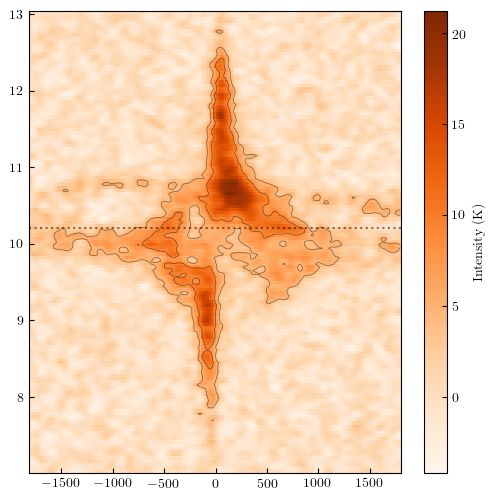

In [8]:
# here we plot the result
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
pcolor = ax.pcolor(offset.value, vel.value, pvdata, shading='auto', cmap='Oranges')
contours = ax.contour(offset.value, vel.value, pvdata, 0.9*np.array([5, 10]), colors='k', linewidths=0.5, alpha=0.5)
fig.colorbar(pcolor, ax=ax, label=r'Intensity (K)')
linestyles = ['--',':']
ax.axhline(v_lsr.value, color='k', ls=':', alpha=0.5)
ax.set_ylim([velinit.value, velend.value])
for i, m in enumerate(mass_IRS1):
    ax.plot(radius, velocity_peri[i], color='k', ls=linestyles[i], label=r'$M_{\star}='+str(m.value)+r'M_{\odot}$')
    ax.plot(radius_neg, velocity_neg_peri[i], color='k', ls=linestyles[i])
ax.plot(radius, velocit_inf, color='C0', label='Infall')
ax.plot(radius_neg, velocit_inf_neg, color='C0')
ax.legend()
bar = AnchoredSizeBar(ax.transData, 120, '120 au', 2, pad=0.1, borderpad=0.5, sep=5,  frameon=False, color='k')#, size_vertical=0.08)
ax.add_artist(bar)
ax.set_xlabel('Offset (au)')
ax.set_ylabel(r'Velocity (km s$^{-1}$)')
# ax.invert_yaxis()

# fig.savefig('pvdiag_C18O_'+str(paangle)+
           #  '_'+str(lengtharcsec)+'arcsec_'+str(widtharcsec)+
           #  'width_kepler'+str(inclination)+'inc_M_nocont.pdf',
           # bbox_inches='tight')
